In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as p
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.gridspec import GridSpec
from scipy.stats import pearsonr
from scipy.spatial import distance
from scipy.stats.mstats import gmean
from sklearn.linear_model import LinearRegression
from statsmodels.nonparametric.smoothers_lowess import lowess 
from skmisc.loess import loess
%matplotlib inline
from itertools import combinations
from itertools import chain
from itertools import product
import statsmodels

from multiprocessing import Pool
import sys
import os
import copy
sns.set_style('white')
sns.set_style('ticks')
sns.set_color_codes()

fgm_simulation_path = '/Users/grantkinsler/Documents/Stanford/Research/StarryNight/Git/starry-night/Simulations/FGM_simulation_callable.py'
sys.path.append(os.path.dirname(os.path.expanduser(fgm_simulation_path)))
from FGM_simulation_callable import simulation, nball_pull, gaussian_fitness

tools_path = '../code/tools.py'
graphs_path = '../code/graphs.py'
sys.path.append(os.path.dirname(os.path.expanduser(tools_path)))
sys.path.append(os.path.dirname(os.path.expanduser(graphs_path)))
import tools
import graphs
from tools import mutant_colorset
from tools import condition_colorset
from tools import renamed_conditions

In [2]:
cov_thresh = 1e6

# fitness_data = p.read_csv('../data/DoubleBC_Merged_Fitness_Atish_Weighted_Default_AllConditions_IncludingOld_swapsremoved.csv')
fitness_data = p.read_csv('../data/fitness_weighted_allconditions_swapsremoved.csv')


merged_fitness_data = fitness_data

In [3]:
mutant_train_set = p.read_csv('../data/mutant_train_set.csv')
training_bcs = mutant_train_set['barcode'].values

mutant_minimal_train_set = p.read_csv('../data/mutant_minimal_train_set.csv')
minimal_training_bcs = mutant_minimal_train_set['barcode'].values

mutant_minimal_test_set = p.read_csv('../data/mutant_minimal_test_set.csv')
minimal_testing_bcs = mutant_minimal_test_set['barcode'].values

mutant_minimal_wothers_train_set = p.read_csv('../data/mutant_minimal+otheradaptive_train_set.csv')
minimal_wothers_training_bcs = mutant_minimal_wothers_train_set['barcode'].values

mutant_minimal_wothers_test_set = p.read_csv('../data/mutant_minimal+otheradaptive_test_set.csv')
minimal_wothers_testing_bcs = mutant_minimal_wothers_test_set['barcode'].values
print(len(minimal_wothers_testing_bcs))

# mutant_justothers_train_set = p.read_csv('../data/mutant_justother_train_set.csv')
# justothers_training_bcs = mutant_justothers_train_set['barcode'].values

# mutant_justothers_test_set = p.read_csv('../data/mutant_justother_test_set.csv')
# justothers_testing_bcs = mutant_justothers_test_set['barcode'].values

76


In [4]:
old_conditions = {
#                   '3':['t3.1','t3.2','t3.3'],
#                   '6':['t6.1','t6.2','t6.3'],
#                   '13':['t13.1','t13.2','t13.3'],
#                   '18':['t18.1','t18.2','t18.3'],
                  '19':['t19.1','t19.2','t19.3'],
#                   '20':['t20.1','t20.2','t20.3'],
#                   '21':['t21.1','t21.2','t21.3'],
#                   '23':['t23.1','t23.2','t23.3'],
                  'M3_Batch_3':['3.1','3.2','3.3'],
                  'M3_Batch_6':['6.1','6.2','6.3'],
                  'M3_Batch_13':['13.1','13.2','13.3'],
                  'M3_Batch_18':['18.1','18.2','18.3'],
#                   'M3_Batch_19':['t19.1','t19.2','t19.3'],
                  'M3_Batch_20':['20.1','20.2','20.3'],
                  'M3_Batch_21':['21.1','21.2','21.3'],
                  'M3_Batch_23':['23.1','23.2','23.3'],
                    ## radicicol
                    ## benomyl
                    ## fluconazole

    
    }

bigbatch_conditions = {
                        '1BB_M3':['A','B','C','D'],
                        '1BB_Baffle':['E','F'],
                        '1BB_1.4%Gluc' :['G','H'],
                        '1BB_1.8%Gluc' :['I','J'],
                        '1BB_0.2MNaCl' :['K','L'],
#                         '1BB_0.2MNaCl' :['K'], 
                        '1BB_0.5MNaCl' :['M','N'],
                        '1BB_0.2MKCl' :['O'],
                        '1BB_0.5MKCl' :['P'],
                        '1BB_8.5uMGdA' :['Q','R'],
                        '1BB_17uMGdA' :['S','T'],
                        '1BB_2ugFlu' :['U','V'],
                        '1BB_0.5ugFlu' :['W','X'],
                        '1BB_1%Raf' :['Y','Z'],
                        '1BB_0.5%Raf' :['AA','BB'],
                        '1BB_1%Gly' :['CC','DD'],
                        '1BB_1%EtOH' :['EE','FF'],
                        '1BB_SucRaf' :['GG'],
                      }



# old_nonm3_conditions = [
# #     '1.4Glucose', '1.6Glucose', '1.7Glucose', '1.8Glucose',
#        '2.5Glucose', '24_Hour_Transfer_PC', 'Benomyl_2ug/mL',
#        'DMSO', 'Ferm_40_Hour_Transfer', 'Ferm_44_Hour_Transfer',
#        'Ferm_50_Hour_Transfer', 'Ferm_54_Hour_Transfer',
#        'Fluconazole_2ug/mL', 'Geldanamycin8.5uM','Radicicol_5uM', 'Resp_5_Day_Transfer',
#        'Resp_7_Day_Transfer']

old_nonm3_conditions = {'Ferm_44hr_Transfer':['t14.1','t14.2','t14.3'],
                  'Ferm_40hr_Transfer':['t15.1','t15.2','t15.3'],
                  'Ferm_54hr_Transfer':['t16.1','t16.2','t16.3'],
                  'Ferm_50hr_Transfer':['t17.1','t17.2','t17.3'],
                  'Resp_24hr_Transfer':['t5.1','t5.2','t5.3'],
                  'Resp_3Day_Transfer':['t7.1','t7.2','t7.3'],
                  'Resp_4Day_Transfer':['t8.1','t8.2','t8.3'],
                  'Resp_5Day_Transfer':['t25.1','t25.2','t25.3'],
                  'Resp_6Day_Transfer':['t26.1','t26.2','t26.3'],
                  'Resp_7Day_Transfer':['t27.1','t27.2','t27.3'],
                  'DMSO':['t1.1','t1.2','t1.3'],
                  'Geldanamycin8.5uM':['t2.4','t2.5','t2.6'],
                    '1.4%':['1.4%-R1','1.4%-R2'],
                    '1.5%':['1.5%-R1','1.5%-R2'],
                    '1.6%':['1.6%-R1','1.6%-R2'],
                    '1.7%':['1.7%-R1','1.7%-R2'],
                    '1.8%':['1.8%-R1','1.8%-R2'],
                    '2.5%':['2.5%-R1','2.5%-R2'],  # not enough usable data
                    'Ben0.4':['Ben0.4-R1','Ben0.4-R2'], # not enough usable data
                    'Ben2':['Ben2-R1','Ben2-R2'], # not enough usable data
#                     'Ben10':['Ben10-R1','Ben10-R2'],
                       }




# m3_conditions = {**old_conditions,}
conditions = {**old_conditions, **bigbatch_conditions}
conditions = {**conditions, **old_nonm3_conditions}
all_conditions = conditions.keys()
all_reps = [rep for reps in conditions.values() for rep in reps]

m3_conditions = list(old_conditions.keys()) + ['1BB_M3']
m3_reps = [rep for condition in m3_conditions for rep in conditions[condition]]




In [5]:
full_neutral_list = [17615,18486,42040,45014,58284,63611,73731,74185,80465,94896
,120600,125697,132511,134852,135750,190551,228237,238783,255561,298344
,308537,316954,317346,335717,411685,454359,469053] 

### from previous list but never has fitness above 3.5% (per gen) in any of 5000bc experiments
supergood_neutral = [17615, 24362, 42040, 71926, 72939, 73802, 80465, 109476, 113483, 
                     134852, 135750, 238783, 263665, 276406, 316954, 335717, 454359] 

### pulled from supergood list and spiked into 1BigBatch experiments
neutral_spikes = [17615,24362,42040,71926,73802,109476,113483,134852,263665,316954]

# neutrals = full_neutral_list
neutrals = list(np.unique(full_neutral_list+supergood_neutral+neutral_spikes))

In [6]:
this_data = merged_fitness_data
this_data = this_data.replace([np.inf, -np.inf], np.nan)
# this_data = this_data.dropna('columns',how='all')
this_data = this_data.dropna()

this_data = this_data.sort_values('barcode')

m3_cols = [col + '_fitness' for col in m3_conditions]
m3_conditions = m3_cols

nonm3_cols = [col + '_fitness' for col in bigbatch_conditions.keys() if (col + '_fitness') not in m3_cols]
nonm3_cols = nonm3_cols + [col + '_fitness' for col in old_nonm3_conditions.keys()]
nonm3_conditions = nonm3_cols

fitness_cols = m3_cols + nonm3_cols

fitness = this_data[fitness_cols].values

n_mutants = fitness.shape[0]
n_conditions = fitness.shape[1]



In [7]:
used_mutants = [bc for bc in this_data['barcode'].values if bc in (list(minimal_wothers_training_bcs) + list(minimal_wothers_testing_bcs))]




([<matplotlib.axis.YTick at 0x11df68780>,
 <a list of 6 Text yticklabel objects>)

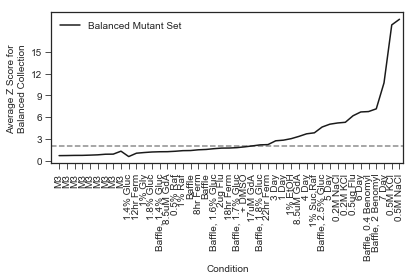

In [28]:
used_mutants = [bc for bc in this_data['barcode'].values if bc in (list(minimal_wothers_training_bcs) + list(minimal_wothers_testing_bcs))]
# used_mutants = [bc for bc in this_data['barcode'].values]

all_mut_locs = sorted(list(np.where(np.isin(this_data['barcode'].values,used_mutants))[0]))

counts = np.unique(this_data['mutation_type'].values[all_mut_locs],return_counts=True)

like_mutant_count_dict = {mut_type:count for mut_type,count in zip(*counts)}

like_mutant_count = [like_mutant_count_dict[mut_type] for mut_type in this_data['mutation_type'].values[all_mut_locs]]
like_mutant_count_m3 = np.repeat(like_mutant_count,len(m3_cols)).reshape(len(like_mutant_count),len(m3_cols))
like_mutant_count_nonm3 = np.repeat(like_mutant_count,len(nonm3_cols)).reshape(len(like_mutant_count),len(nonm3_cols))     
# rel_mutant_count_m3 = 

m3_means = np.nanmean(this_data[m3_cols].values[all_mut_locs,:],axis=1)
m3_stds = np.nanstd(this_data[m3_cols].values[all_mut_locs,:],axis=1)

repeated_means = np.repeat(m3_means,len(nonm3_cols)).reshape(len(m3_means),len(nonm3_cols))
repeated_stds = np.repeat(m3_stds,len(nonm3_cols)).reshape(len(m3_stds),len(nonm3_cols))
nonm3_z_scores = np.abs((this_data[nonm3_cols].values[all_mut_locs,:]-repeated_means)/repeated_stds)

repeated_means = np.repeat(m3_means,len(m3_cols)).reshape(len(m3_means),len(m3_cols))
repeated_stds = np.repeat(m3_stds,len(m3_cols)).reshape(len(m3_stds),len(m3_cols))
m3_z_scores = np.abs((this_data[m3_cols].values[all_mut_locs,:]-repeated_means)/repeated_stds)

mean_m3_z_scores = np.sum(m3_z_scores/like_mutant_count_m3,axis=0)/len(counts[0])
mean_nonm3_z_scores = np.sum(nonm3_z_scores/like_mutant_count_nonm3,axis=0)/len(counts[0])

plt.figure()

sorted_nonm3_cols = np.asarray(nonm3_cols)[np.argsort(np.sum(nonm3_z_scores/like_mutant_count_nonm3,axis=0)/len(counts[0]))]
sorted_m3_cols = np.asarray(m3_cols)[np.argsort(np.sum(m3_z_scores/like_mutant_count_m3,axis=0)/len(counts[0]))]

sorted_mean_m3_z_scores = sorted(np.sum(m3_z_scores/like_mutant_count_m3,axis=0)/len(counts[0]))
sorted_mean_nonm3_z_scores = sorted(np.sum(nonm3_z_scores/like_mutant_count_nonm3,axis=0)/len(counts[0]))

plt.plot(sorted_mean_m3_z_scores+sorted_mean_nonm3_z_scores,'-',color='k',alpha=1.0,label='Balanced Mutant Set')

all_cols = list(sorted_m3_cols)+list(sorted_nonm3_cols)
plt.xticks(range(len(all_cols)),[renamed_conditions[col.split('_fitness')[0]] for col in (all_cols)],rotation=90)


plt.legend()
# plt.ylim(0,7)
plt.xlim(-1,len(m3_conditions)+len(nonm3_conditions)-0.5)
plt.ylabel('Average Z Score for\nBalanced Collection')
plt.xlabel('Condition')

plt.tight_layout()
plt.axhline(2,color='k',linestyle='--',alpha=0.5)
plt.yticks(range(0,16,3),range(0,16,3))
# plt.savefig('z_scores_minimal_comparison.pdf',bbox_inches='tight')

In [9]:
gene_list = ['IRA1_nonsense','GPB2','PDE2','Diploid']

mean_std_bygene = {}
for gene in gene_list:
    
    used_mutants = [bc for bc in this_data[this_data['mutation_type']==gene]['barcode'].values]
    this_gene_locs =sorted(list(np.where(np.isin(this_data['barcode'].values,used_mutants))[0]))
    
    m3_means = np.nanmean(this_data[m3_cols].values[this_gene_locs,:],axis=1)
    m3_stds = np.nanstd(this_data[m3_cols].values[this_gene_locs,:],axis=1)

    mean_std_bygene[gene] = [np.mean(m3_means),np.mean(m3_stds)]

In [10]:
# last_subtle = 17
first_nonsubtle = np.where(np.asarray(sorted_mean_nonm3_z_scores) > 2.0)[0][0]
print('subtle: ',list(sorted_m3_cols) + list(sorted_nonm3_cols[:first_nonsubtle]))
print('strong: ',list(sorted_nonm3_cols[first_nonsubtle:]))

this_data = merged_fitness_data
this_data = this_data.replace([np.inf, -np.inf], np.nan)
this_data = this_data.dropna('columns',how='all')
this_data = this_data.dropna()
this_data = this_data.sort_values('barcode')

datasets = {}

gene_list = ['IRA1_nonsense','GPB2','PDE2','Diploid','ExpNeutral']

datasets['subtle_to_strong_wothers'] = tools.situate_data(this_data,list(sorted_m3_cols) + list(sorted_nonm3_cols[:first_nonsubtle]),list(sorted_nonm3_cols[first_nonsubtle:]),
                  minimal_wothers_training_bcs,minimal_wothers_testing_bcs,gene_list)
datasets['subtle_to_strong_wothers_fixed_mutants'] = tools.situate_data(this_data,list(sorted_m3_cols) + list(sorted_nonm3_cols[:first_nonsubtle]),list(sorted_nonm3_cols[first_nonsubtle:]),
                  minimal_wothers_training_bcs,minimal_wothers_testing_bcs,gene_list,fixed_mutant_sets=True)

datasets['strong_to_subtle_wothers'] = tools.situate_data(this_data,list(sorted_nonm3_cols[first_nonsubtle:]),list(sorted_m3_cols) + list(sorted_nonm3_cols[:first_nonsubtle]),
                  minimal_wothers_training_bcs,minimal_wothers_testing_bcs,gene_list)
datasets['strong_to_subtle_wothers_fixed_mutants'] = tools.situate_data(this_data,list(sorted_nonm3_cols[first_nonsubtle:]),list(sorted_m3_cols) + list(sorted_nonm3_cols[:first_nonsubtle]),
                  minimal_wothers_training_bcs,minimal_wothers_testing_bcs,gene_list,fixed_mutant_sets=True)




subtle:  ['M3_Batch_23_fitness', 'M3_Batch_6_fitness', 'M3_Batch_18_fitness', 'M3_Batch_3_fitness', 'M3_Batch_20_fitness', 'M3_Batch_13_fitness', '19_fitness', '1BB_M3_fitness', 'M3_Batch_21_fitness', '1BB_1.4%Gluc_fitness', 'Ferm_44hr_Transfer_fitness', '1BB_1%Gly_fitness', '1BB_1.8%Gluc_fitness', '1.4%_fitness', 'Geldanamycin8.5uM_fitness', '1BB_0.5%Raf_fitness', '1BB_1%Raf_fitness', '1.5%_fitness', 'Ferm_40hr_Transfer_fitness', '1BB_Baffle_fitness', '1.6%_fitness', '1BB_2ugFlu_fitness', 'Ferm_50hr_Transfer_fitness', '1.7%_fitness', 'DMSO_fitness']
strong:  ['1BB_17uMGdA_fitness', '1.8%_fitness', 'Ferm_54hr_Transfer_fitness', 'Resp_3Day_Transfer_fitness', 'Resp_24hr_Transfer_fitness', '1BB_1%EtOH_fitness', '1BB_8.5uMGdA_fitness', 'Resp_4Day_Transfer_fitness', '1BB_SucRaf_fitness', '2.5%_fitness', 'Resp_5Day_Transfer_fitness', '1BB_0.2MNaCl_fitness', '1BB_0.2MKCl_fitness', '1BB_0.5ugFlu_fitness', 'Resp_6Day_Transfer_fitness', 'Ben0.4_fitness', 'Ben2_fitness', 'Resp_7Day_Transfer_fitne

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/linalg/basic.py:1226: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


1 0.5059630450118833
2 0.720914688061188
3 0.7218324352679876
4 0.7078893156633462
5 0.6910012819923146
6 0.7089221529651355
7 0.7291859055778047
8 0.7823171944752093
9 0.7883347004443251
10 0.759307752672688
11 0.7552700876697782
12 0.7521061736885813
13 0.7391640115573719
14 0.7409404538136157
15 0.7539421203447269
16 0.745985104130915
17 0.7618703193637425
18 0.7505280405948825
19 0.7392601432232723
20 0.720524725553906
21 0.7208185491547798
22 0.7019016290016626
23 0.6743507824893442
24 0.6681773843011426
25 0.447427576929617
1 0.5059630450118833
2 0.720914688061188
3 0.7218324352679876
4 0.7078893156633462
5 0.6910012819923146
6 0.7089221529651355
7 0.7291859055778047
8 0.7823171944752093
9 0.7883347004443251
10 0.759307752672688
11 0.7552700876697782
12 0.7521061736885813
13 0.7391640115573719
14 0.7409404538136157
15 0.7539421203447269
16 0.745985104130915
17 0.7618703193637425
18 0.7505280405948825
19 0.7392601432232723
20 0.720524725553906
21 0.7208185491547798
22 0.7019016290

(array([8]),)
(array([5]),)


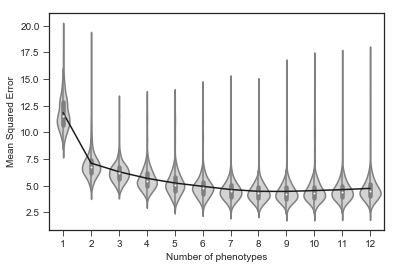

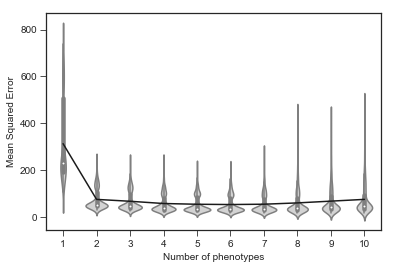

In [11]:
sets = ['subtle_to_strong_wothers_fixed_mutants','strong_to_subtle_wothers_fixed_mutants']

for this_set in sets:
    plt.figure()
    dataset = datasets[this_set]
    all_guesses = dataset['CV_all_guesses']
    sns.violinplot(data=np.asarray(all_guesses),color='lightgray',alpha=0.1)
    plt.plot(np.mean(all_guesses,axis=0),'k',label='Average')
    print(np.where(np.mean(all_guesses,axis=0)==np.min(np.mean(all_guesses,axis=0))))

    plt.xticks(range(len(np.mean(all_guesses,axis=0))),range(1,len(np.mean(all_guesses,axis=0))+1))
    plt.xlabel('Number of phenotypes')
    plt.ylabel('Mean Squared Error')
#     plt.ylim(0,10)

    [(i,j) for i,j in enumerate(np.mean(all_guesses,axis=0))]
# plt.savefig('cross_validation_subtle_modelselection_balancedtraintest_fulldistribution.pdf',bbox_inches='tight')

0.0005257116969838376 0.00040692480120707776 0.7740455529936368
8
0.007789470815481622 0.0042194913444032305 0.541691655871791
5


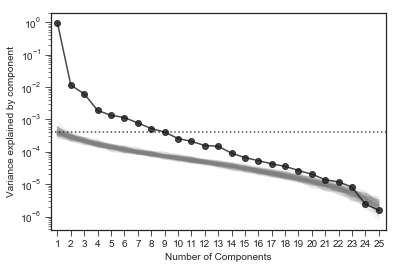

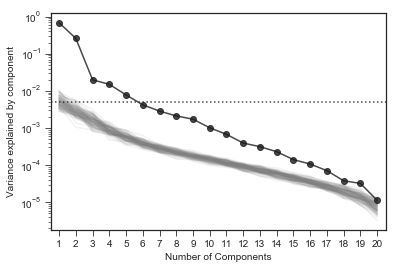

In [12]:
ax = plt.subplot(111)

these_cols = list(sorted_m3_cols) + list(sorted_nonm3_cols[:first_nonsubtle])
# these_cols = list(sorted_m3_cols) + list(sorted_nonm3_cols[:-2])


this_fitness = this_data[this_data['barcode'].isin(list(minimal_wothers_training_bcs))][these_cols].values
this_error = this_data[this_data['barcode'].isin(list(minimal_wothers_training_bcs))][[col.replace('_fitness','_error') for col in these_cols ]].values

# this_fitness = this_data[this_data['barcode'].isin(list(minimal_wothers_training_bcs)+list(minimal_wothers_testing_bcs))][list(sorted_m3_cols) + list(sorted_nonm3_cols[:first_nonsubtle])].values
# this_error = this_data[this_data['barcode'].isin(list(minimal_wothers_training_bcs)+list(minimal_wothers_testing_bcs))][[col.replace('_fitness','_error') for col in list(sorted_m3_cols) + list(sorted_nonm3_cols[:first_nonsubtle])]].values

tools.svd_noise_comparison_figure(ax,this_fitness,this_error,100,yscale='log')

plt.figure()
ax = plt.subplot(111)

these_cols = list(sorted_nonm3_cols[first_nonsubtle:])
# these_cols = list(sorted_m3_cols) + list(sorted_nonm3_cols[:-2])


this_fitness = this_data[this_data['barcode'].isin(list(minimal_wothers_training_bcs))][these_cols].values
this_error = this_data[this_data['barcode'].isin(list(minimal_wothers_training_bcs))][[col.replace('_fitness','_error') for col in these_cols ]].values

# this_fitness = this_data[this_data['barcode'].isin(list(minimal_wothers_training_bcs)+list(minimal_wothers_testing_bcs))][list(sorted_m3_cols) + list(sorted_nonm3_cols[:first_nonsubtle])].values
# this_error = this_data[this_data['barcode'].isin(list(minimal_wothers_training_bcs)+list(minimal_wothers_testing_bcs))][[col.replace('_fitness','_error') for col in list(sorted_m3_cols) + list(sorted_nonm3_cols[:first_nonsubtle])]].values

tools.svd_noise_comparison_figure(ax,this_fitness,this_error,100,yscale='log')



Text(0.25,0.05,'5 component model, $R^2$ = 0.985')

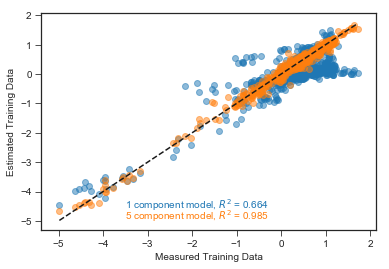

In [13]:
both_old = dataset['both_old']
dhats = dataset['dhats']
model = dataset['CV_best_rank_index']
model = 4

ax2 = plt.subplot(111)
plt.scatter(both_old,dhats[0],alpha=0.5,label='1 component model')
plt.scatter(both_old,dhats[model],alpha=0.5,label=f'{model + 1} component model')
plt.xlabel('Measured Training Data')
plt.ylabel('Estimated Training Data')
this_min = min([np.min(both_old),np.min(dhats[model])])
this_max = max([np.max(both_old),np.max(dhats[model])])
plt.plot([this_min,this_max],[this_min,this_max],'k--')

xdisplay, ydisplay = ax2.transAxes.transform_point((0.3, 0.1))

plt.annotate(fr'1 component model, $R^2$ = {tools.var_explained(both_old,dhats[0])[0]:.3g}',xy=(0.25,0.1),
             color=sns.color_palette()[0],xycoords='axes fraction')

xdisplay, ydisplay = ax2.transAxes.transform_point((0.3, 0.0))
plt.annotate(fr'{model+1} component model, $R^2$ = {tools.var_explained(both_old,dhats[model])[0]:.3g}',xy=(0.25,0.05),
             color=sns.color_palette()[1],xycoords='axes fraction')
    # plt.legend()
# plt.savefig('overall_train_subtle_prediction.pdf',bbox_inches='tight')

2 0.6218535423275329
3 0.8091822880575994
4 0.8254267799042485
5 0.8509064870144765


<Figure size 432x288 with 0 Axes>

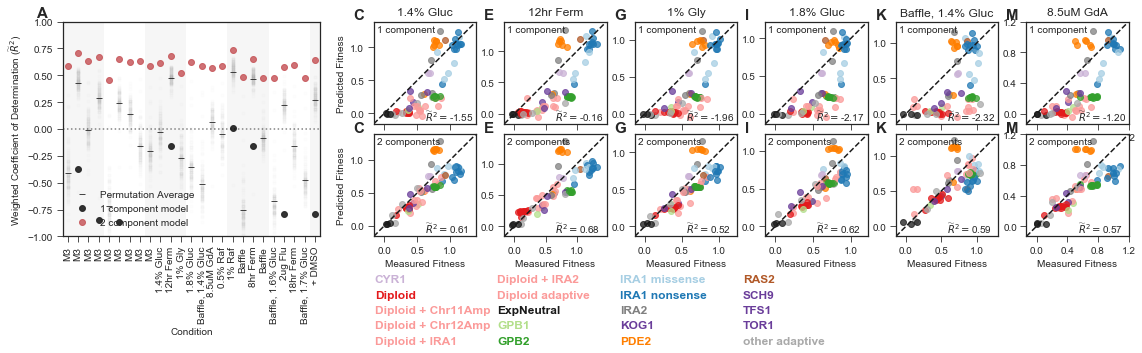

<Figure size 432x288 with 0 Axes>

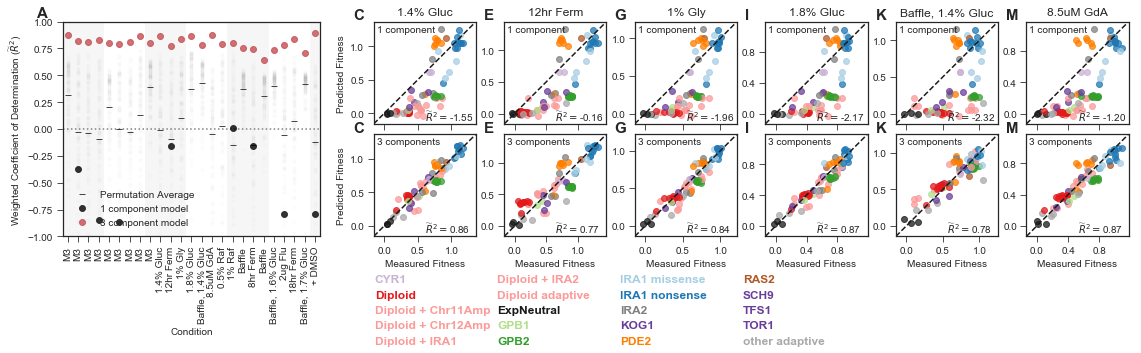

<Figure size 432x288 with 0 Axes>

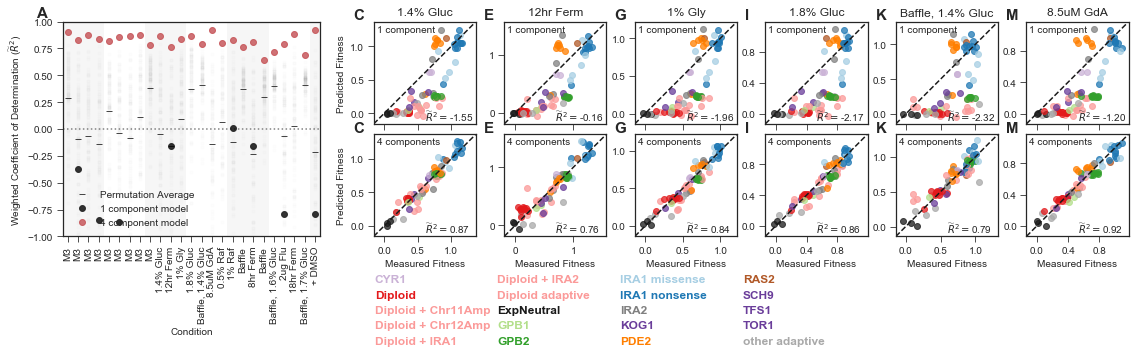

<Figure size 432x288 with 0 Axes>

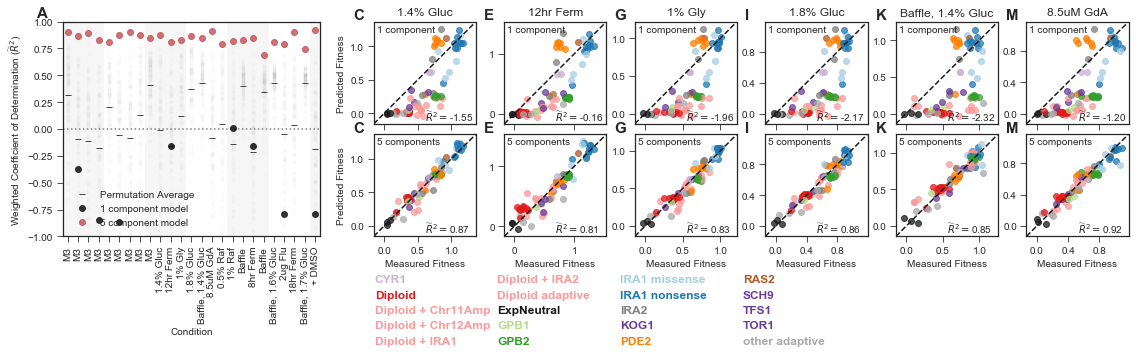

In [34]:
example_names= sorted_nonm3_cols[:6]

for model in [1,2,3,4]:
    plt.figure()
    graphs.Figure4_w_examples(datasets['strong_to_subtle_wothers'],gene_list,this_data,[col for col in example_names],model=model)
    plt.savefig(f'strong_{model}.pdf',bbox_inches='tight')


In [17]:
this_data[sorted_nonm3_cols[0]]

0      0.354108
1      1.065666
2      0.356698
3      0.872106
4      0.814801
5      1.165605
8      1.171530
9      0.370010
12     1.073982
13     1.094101
14     0.303593
15     0.746316
16     0.082373
17    -0.024115
18     0.766067
19     0.320897
20     0.380345
21     0.782335
23     0.515100
24     0.764274
25     0.483534
26     0.489442
28     0.386044
30     0.318381
31     0.723704
33     0.205100
34     0.323120
35     0.865081
36     1.117824
37     0.473430
         ...   
474    0.083652
475    0.019942
476    0.235292
477    0.019500
478    0.041143
479    0.838159
480    0.334294
481    0.019641
483    0.356045
485    0.340160
486    0.316834
487    0.065868
490    0.060570
491    0.373548
492    0.328932
493    0.357040
496    0.425577
497    0.171835
498    0.107572
499    0.148509
503    0.363559
505    0.589504
506    0.022693
508    0.333744
514    0.190128
515    0.366504
516    0.297256
518    0.064079
520    0.310126
522    0.078433
Name: 1BB_1.4%Gluc_fitne

In [32]:
# THE_data = this_data[this_data['barcode'].isin(list(minimal_wothers_training_bcs)+list(minimal_wothers_testing_bcs))]
THE_data = this_data[this_data['barcode'].isin(list(minimal_wothers_testing_bcs))]
THE_data = this_data[this_data['barcode'].isin(list(minimal_wothers_training_bcs))]

all_ve = {}

for col in list(sorted_m3_cols) + list(sorted_nonm3_cols[:16]):
    this_f = THE_data[col].values
    this_e = THE_data[col.replace('_fitness','_error')].values
    types = THE_data['mutation_type'].values
    
    all_ve[col] = []
    
    for i in range(50):
        resampled = np.random.normal(this_f,this_e)
        ve = tools.var_explained_weighted_by_type(this_f,resampled,types)
        
        all_ve[col].append(ve[0])
        
avg_ve = {col:np.mean(l) for col,l in all_ve.items()}
        
        

In [33]:
avg_ve

{'1.4%_fitness': 0.9723121833520455,
 '1.5%_fitness': 0.9475255103040615,
 '1.6%_fitness': 0.9848624321925032,
 '1.7%_fitness': 0.975587988472527,
 '19_fitness': 0.9923075104203656,
 '1BB_0.5%Raf_fitness': 0.9915737907626427,
 '1BB_1%Gly_fitness': 0.9825970605119645,
 '1BB_1%Raf_fitness': 0.9779185675243126,
 '1BB_1.4%Gluc_fitness': 0.9883692699112475,
 '1BB_1.8%Gluc_fitness': 0.9858397126512228,
 '1BB_2ugFlu_fitness': 0.9858439306311644,
 '1BB_Baffle_fitness': 0.9885631159572411,
 '1BB_M3_fitness': 0.9925617651916702,
 'DMSO_fitness': 0.9757465126243927,
 'Ferm_40hr_Transfer_fitness': 0.9822687654155479,
 'Ferm_44hr_Transfer_fitness': 0.994982559080437,
 'Ferm_50hr_Transfer_fitness': 0.985686332790887,
 'Geldanamycin8.5uM_fitness': 0.9188065764628692,
 'M3_Batch_13_fitness': 0.9900988259240571,
 'M3_Batch_18_fitness': 0.9858562123466459,
 'M3_Batch_20_fitness': 0.933609071039943,
 'M3_Batch_21_fitness': 0.9760777344615684,
 'M3_Batch_23_fitness': 0.9766195319042831,
 'M3_Batch_3_fitne

In [29]:
# THE_data = this_data[this_data['barcode'].isin(list(minimal_wothers_training_bcs)+list(minimal_wothers_testing_bcs))]
THE_data = this_data[this_data['barcode'].isin(list(minimal_wothers_testing_bcs))]


all_ve = {}

for col in list(sorted_nonm3_cols[16:]):
    this_f = THE_data[col].values
    this_e = THE_data[col.replace('_fitness','_error')].values
    types = THE_data['mutation_type'].values
    
    all_ve[col] = []
    
    for i in range(50):
        resampled = np.random.normal(this_f,this_e)
        ve = tools.var_explained_weighted_by_type(this_f,resampled,types)
        
        all_ve[col].append(ve[0])
        
avg_ve = {col:np.mean(l) for col,l in all_ve.items()}
        
        

In [30]:
avg_ve

{'1.8%_fitness': 0.9890004758162014,
 '1BB_0.2MKCl_fitness': 0.9795914550663215,
 '1BB_0.2MNaCl_fitness': 0.9921450027704941,
 '1BB_0.5MKCl_fitness': 0.9866001622308798,
 '1BB_0.5MNaCl_fitness': 0.9859305791998757,
 '1BB_0.5ugFlu_fitness': 0.9890035234358637,
 '1BB_1%EtOH_fitness': 0.9873886467820039,
 '1BB_17uMGdA_fitness': 0.9707105375781547,
 '1BB_8.5uMGdA_fitness': 0.9455557403533449,
 '1BB_SucRaf_fitness': 0.8383123136288552,
 '2.5%_fitness': 0.7962417139202946,
 'Ben0.4_fitness': 0.9197244890561513,
 'Ben2_fitness': 0.9821653193108727,
 'Ferm_54hr_Transfer_fitness': 0.9794769038196165,
 'Resp_24hr_Transfer_fitness': 0.9441220925030458,
 'Resp_3Day_Transfer_fitness': 0.979392564737396,
 'Resp_4Day_Transfer_fitness': 0.9722552557032539,
 'Resp_5Day_Transfer_fitness': 0.9918549250927496,
 'Resp_6Day_Transfer_fitness': 0.9908407438808718,
 'Resp_7Day_Transfer_fitness': 0.9648344714513521}